In [1]:
import numpy as np
from scipy.stats import distributions
import matplotlib.pyplot as plt
from classes.dpm import BaseMeasure, DPM, NormalBaseMeasure, ExponentialBaseMeasure
from classes.likelihood import NormalLikelihood, PoissonLikelihood
from classes.variables import Normal, InvGamma
plt.style.use("bmh")

Create a mixture of poisson distributed data

In [2]:
mu1 = 2
mu2 = 5
w1 = 0.5
y = np.concatenate(
    [
        distributions.poisson.rvs(mu=mu1, size=int(w1*20)), 
        distributions.poisson.rvs(mu=mu2, size=int((1-w1)*20))
    ]
)
# y = np.array([ 3,  2,  2,  2,  3,  1,  4,  2,  1,  1, 11,  5,  5, 11,  8,  8,  9,
#        17,  8, 10])


def f(x, w1=w1):
    return distributions.poisson.pmf(x, mu=mu1) * w1 + distributions.poisson.pmf(x, mu=mu2) * (1-w1)

xmin = np.min(y)
xmax = np.max(y) + 3
xrange = np.arange(xmin, xmax, 1)

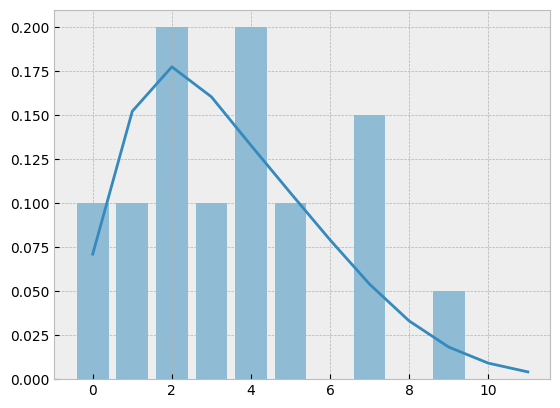

In [3]:
a, b = np.unique(y, return_counts=True)
plt.bar(a, b/np.sum(b), alpha=0.5)
plt.plot(xrange, f(xrange))

In [4]:
dpm = DPM(ExponentialBaseMeasure(), PoissonLikelihood(), M=10)

In [5]:
dpm.set_dataset(y, np.zeros_like(y))
dpm.set_measures([[1]])

In [6]:
dpm.sample(200)

step:   40/ 200 : [0, 0, 0, 0, 1, 0, 2, 1, 2, 1, 3, 1, 3, 1, 4, 0, 1, 1, 1, 1]
step:   80/ 200 : [0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 0]
step:  120/ 200 : [0, 0, 1, 1, 0, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
step:  160/ 200 : [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [7]:
chain = dpm._dpm_chain
results = {"w": chain.w, "theta": chain.phi, "n_clusters": chain.n}

In [8]:
def plot_posterior_density(x, results:dict):
    w = results["w"][:]
    t = results["theta"][:]

    big_X = np.arange(0, np.max(x)+3, 1)

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    a, b = np.unique(results["n_clusters"], return_counts=True)
    ax[0].bar(x=a, height=b)
    all_y = []
    for i in range(len(w)):
        len_w = len(w[i])

        y = []
        mu = np.array(t[i])[:,0]

        for j in range(len_w):
            y.append(w[i][j] * distributions.poisson.pmf(big_X, mu[j]))

        y = np.sum(y, axis=0)
        all_y.append(y)

    a, b = np.unique(x, return_counts=True)
    ax[1].stem(a, b/np.sum(b))

    all_y = np.array(all_y)

    s = np.std(all_y, axis=0)
    m = np.mean(all_y, axis=0)
    ax[1].plot(big_X, m, linestyle="dashed")
    ax[1].fill_between(big_X, m + 1.96*s, np.clip(m - 1.96*s, 0, None), alpha=0.2, color="tab:blue")


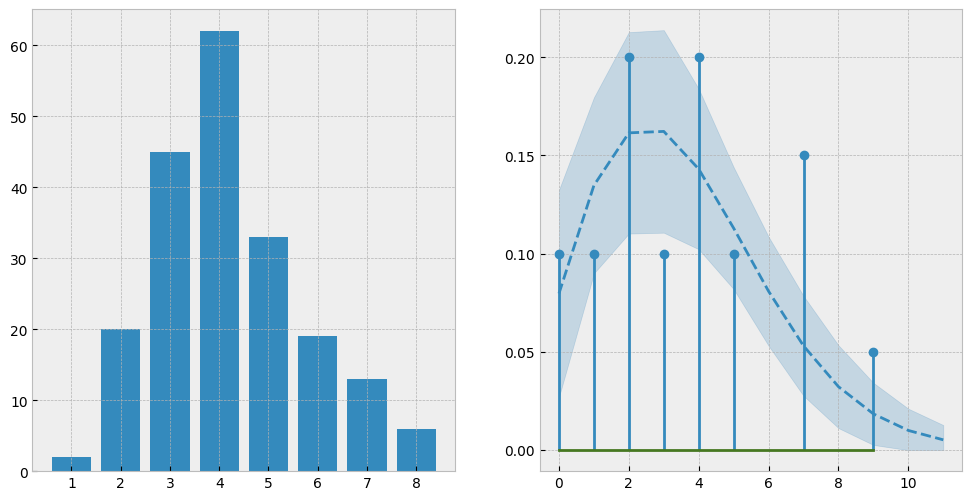

In [9]:
plot_posterior_density(y, results)